# 16 · Comparación de detectores de bordes bajo ruido (gris)

Comparamos **Sobel**, **Laplaciano** y **Canny** con y sin ruido (Gaussiano y Sal & Pimienta) en una imagen **en escala de grises**.

**Métricas:** Densidad de bordes, Precision/Recall/F1 contra Canny limpio como referencia, y conectividad (componentes conexas y tamaño medio).

## 1) Cargar imagen (gris)

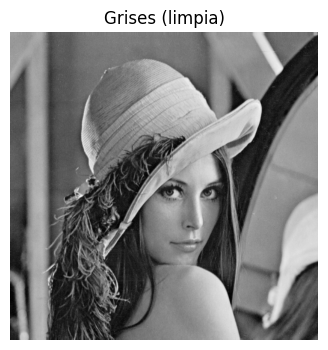

In [8]:
import cv2, numpy as np, matplotlib.pyplot as plt

IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\lenna.png"
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(4,4))
plt.imshow(img_gray, cmap='gray'); plt.title("Grises (limpia)"); plt.axis("off"); plt.show()


## 2) Ruido Gaussiano y Sal & Pimienta

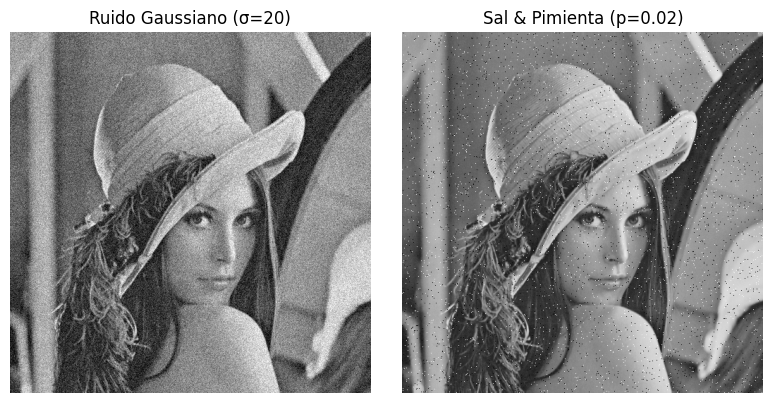

In [9]:
def add_gaussian_noise_gray(img, mean=0.0, sigma=20.0):
    noise = np.random.normal(mean, sigma, img.shape).astype(np.float32)
    out = img.astype(np.float32) + noise
    return np.clip(out, 0, 255).astype(np.uint8)

def add_salt_pepper_gray(img, prob=0.02):
    noisy = img.copy()
    h, w = img.shape
    mask = np.random.rand(h, w)
    noisy[mask < prob/2] = 0
    noisy[mask > 1 - prob/2] = 255
    return noisy

img_gauss = add_gaussian_noise_gray(img_gray, sigma=20.0)
img_sp    = add_salt_pepper_gray(img_gray, prob=0.02)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_gauss, cmap='gray'); plt.title("Ruido Gaussiano (σ=20)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_sp,    cmap='gray'); plt.title("Sal & Pimienta (p=0.02)"); plt.axis("off")
plt.tight_layout(); plt.show()


## 3) Detectores: Sobel, Laplaciano, Canny

In [10]:
def sobel_edges(gray, ksize=3, thresh_percentile=85):
    Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=ksize)
    mag = cv2.magnitude(Ix, Iy)
    t = np.percentile(mag, thresh_percentile)
    edges = (mag >= t).astype(np.uint8) * 255
    return edges, mag

def laplacian_edges(gray, ksize=3, thresh_percentile=85):
    lap = cv2.Laplacian(gray, cv2.CV_32F, ksize=ksize)
    lap_abs = np.abs(lap)
    t = np.percentile(lap_abs, thresh_percentile)
    edges = (lap_abs >= t).astype(np.uint8) * 255
    return edges, lap_abs

def canny_edges(gray, low=80, high=160):
    return cv2.Canny(gray, low, high, L2gradient=True)


## 4) Referencia y mapas bajo ruido

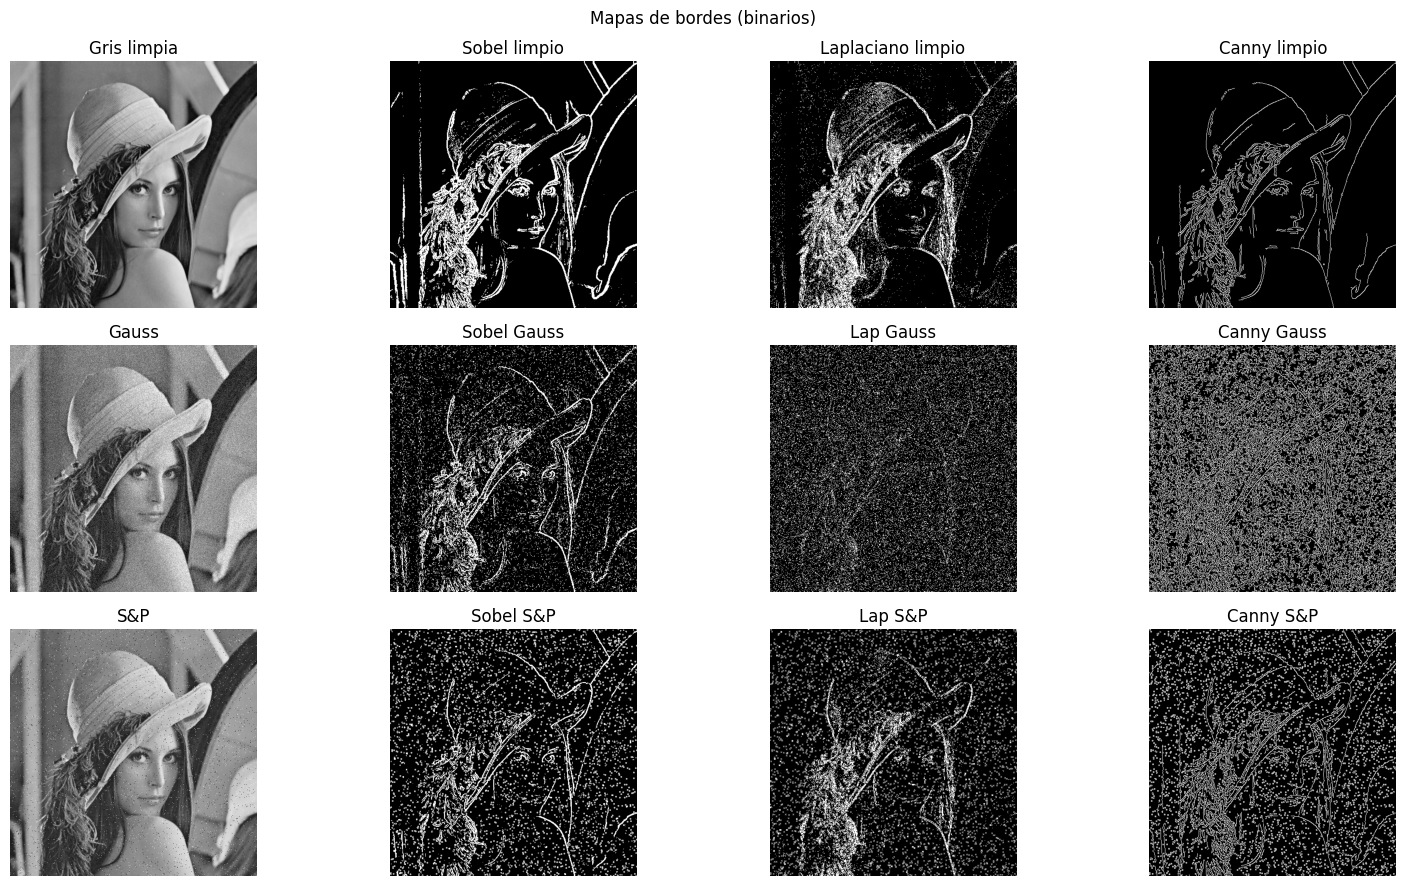

In [11]:
# Referencia: Canny en limpio
ref = canny_edges(img_gray, 80, 160)

# En limpio
sob_clean, _ = sobel_edges(img_gray)
lap_clean, _ = laplacian_edges(img_gray)
cny_clean    = ref

# Con Gauss
sob_gauss, _ = sobel_edges(img_gauss)
lap_gauss, _ = laplacian_edges(img_gauss)
cny_gauss    = canny_edges(img_gauss, 80, 160)

# Con S&P
sob_sp, _ = sobel_edges(img_sp)
lap_sp, _ = laplacian_edges(img_sp)
cny_sp    = canny_edges(img_sp, 80, 160)

def show_grid(title, imgs, names, cmap='gray', cols=4):
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(4*cols, 3*rows))
    for i,(im,name) in enumerate(zip(imgs,names),1):
        plt.subplot(rows,cols,i)
        plt.imshow(im, cmap=cmap); plt.title(name); plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_grid("Mapas de bordes (binarios)", 
          [img_gray, sob_clean, lap_clean, cny_clean,
           img_gauss, sob_gauss, lap_gauss, cny_gauss,
           img_sp, sob_sp, lap_sp, cny_sp],
          ["Gris limpia","Sobel limpio","Laplaciano limpio","Canny limpio",
           "Gauss","Sobel Gauss","Lap Gauss","Canny Gauss",
           "S&P","Sobel S&P","Lap S&P","Canny S&P"]) 


## 5) Métricas: densidad, solapamiento con referencia y conectividad

In [12]:
def edge_density(edge_bin):
    return int((edge_bin>0).sum())

def prf_against_ref(edge_bin, ref_bin):
    A = (edge_bin>0).astype(np.uint8)
    R = (ref_bin>0).astype(np.uint8)
    TP = int(np.logical_and(A==1, R==1).sum())
    FP = int(np.logical_and(A==1, R==0).sum())
    FN = int(np.logical_and(A==0, R==1).sum())
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return TP, FP, FN, prec, rec, f1

def connectivity_stats(edge_bin):
    A = (edge_bin>0).astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(A, connectivity=8)
    sizes = [int((labels==i).sum()) for i in range(1, num_labels)]
    ncomp = len(sizes)
    mean_sz = float(np.mean(sizes)) if sizes else 0.0
    return ncomp, mean_sz

import pandas as pd
rows = []

def add_row(tag, edge_map):
    den = edge_density(edge_map)
    TP,FP,FN,prec,rec,f1 = prf_against_ref(edge_map, ref)
    ncomp, msz = connectivity_stats(edge_map)
    rows.append({
        "Caso": tag, "Densidad": den, "TP": TP, "FP": FP, "FN": FN,
        "Precisión": prec, "Recall": rec, "F1": f1,
        "CC (#)": ncomp, "CC tamaño medio": msz
    })

# Limpio
add_row("Sobel limpio", sob_clean)
add_row("Laplaciano limpio", lap_clean)
add_row("Canny limpio (ref)", cny_clean)

# Gauss
add_row("Sobel Gauss", sob_gauss)
add_row("Laplaciano Gauss", lap_gauss)
add_row("Canny Gauss", cny_gauss)

# S&P
add_row("Sobel S&P", sob_sp)
add_row("Laplaciano S&P", lap_sp)
add_row("Canny S&P", cny_sp)

df = pd.DataFrame(rows)
df


,Caso,Densidad,TP,FP,FN,Precisión,Recall,F1,CC (#),CC tamaño medio
0,Sobel limpio,39343,15390,23953,245,0.391175,0.984330,0.559860,686,57.351312
1,Laplaciano limpio,39436,7218,32218,8417,0.183031,0.461657,0.262134,4401,8.960691
2,Canny limpio (ref),15635,15635,0,0,1.000000,1.000000,1.000000,299,52.290970
3,Sobel Gauss,39323,10868,28455,4767,0.276378,0.695107,0.395502,7828,5.023378
4,Laplaciano Gauss,39353,2871,36482,12764,0.072955,0.183626,0.104423,14770,2.664387
5,Canny Gauss,77519,10261,67258,5374,0.132368,0.656284,0.220302,3676,21.087867
6,Sobel S&P,39324,9786,29538,5849,0.248856,0.625903,0.356120,2900,13.560000
7,Laplaciano S&P,39550,4944,34606,10691,0.125006,0.316214,0.179179,3959,9.989896
8,Canny S&P,43092,13491,29601,2144,0.313074,0.862872,0.459448,2858,15.077677


## 6) Lectura de resultados

- **Densidad** alta → bordes más gruesos o ruido.
- **F1** contra Canny limpio indica qué tanto se parece el mapa bajo ruido al de referencia.
- **CC**: más componentes pequeñas → bordes fragmentados; mayor tamaño medio → bordes más continuos.

**Regla práctica**: con **Gaussiano**, Canny y Sobel suelen comportarse bien; con **Sal & Pimienta**, Canny resiste mejor que Sobel/Laplaciano, pero una **mediana previa** ayuda mucho.

## 7) Pre-filtrado antes de la detección de bordes
Aplicamos un **suavizado previo** y medimos el impacto en las métricas:

- **Ruido Gaussiano** → *Gaussiano previo* (`GaussianBlur 5×5, σ=1.0`) antes de **Canny**.
- **Sal & Pimienta** → *Mediana previa* (`medianBlur k=3`) antes de **Canny**.


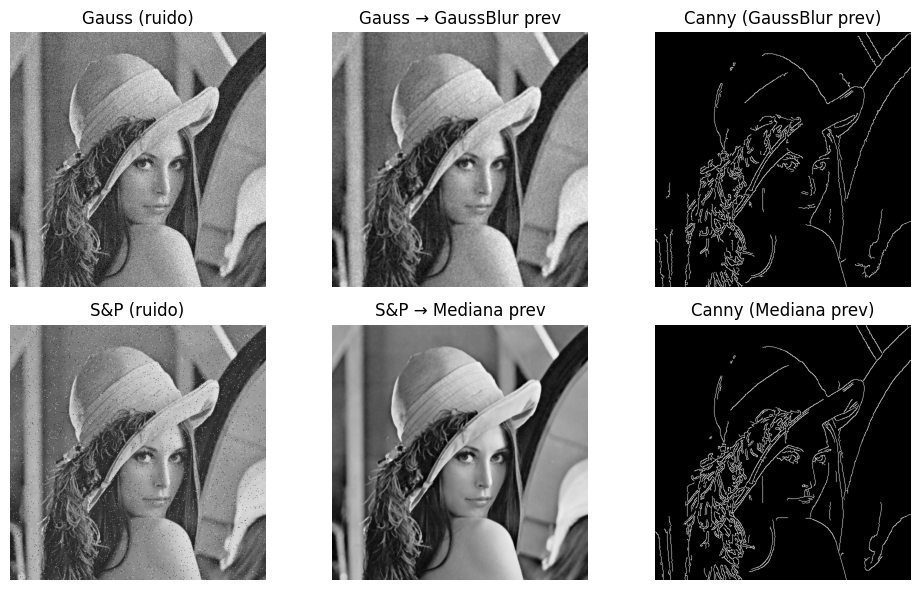

In [13]:
# Pre-filtros
gauss_pref = cv2.GaussianBlur(img_gauss, (5,5), 1.0)
sp_pref    = cv2.medianBlur(img_sp, 3)

# Edge maps con pre-filtrado
cny_gauss_pref = canny_edges(gauss_pref, 80, 160)
cny_sp_pref    = canny_edges(sp_pref,    80, 160)

# Visualización
plt.figure(figsize=(10,6))
plt.subplot(2,3,1); plt.imshow(img_gauss, cmap='gray');      plt.title("Gauss (ruido)"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(gauss_pref, cmap='gray');     plt.title("Gauss → GaussBlur prev"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(cny_gauss_pref, cmap='gray'); plt.title("Canny (GaussBlur prev)"); plt.axis("off")

plt.subplot(2,3,4); plt.imshow(img_sp, cmap='gray');         plt.title("S&P (ruido)"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(sp_pref, cmap='gray');        plt.title("S&P → Mediana prev"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(cny_sp_pref, cmap='gray');    plt.title("Canny (Mediana prev)"); plt.axis("off")
plt.tight_layout(); plt.show()

## 8) Métricas adicionales con pre-filtrado

In [14]:
# Añadimos filas a la tabla existente `df` con los nuevos casos
def add_row(tag, edge_map):
    den = int((edge_map>0).sum())
    TP,FP,FN,prec,rec,f1 = prf_against_ref(edge_map, ref)
    ncomp, msz = connectivity_stats(edge_map)
    return {
        "Caso": tag, "Densidad": den, "TP": TP, "FP": FP, "FN": FN,
        "Precisión": prec, "Recall": rec, "F1": f1,
        "CC (#)": ncomp, "CC tamaño medio": msz
    }

extra_rows = []
extra_rows.append(add_row("Canny Gauss (GaussBlur prev)", cny_gauss_pref))
extra_rows.append(add_row("Canny S&P (Mediana prev)",     cny_sp_pref))

import pandas as pd
df2 = pd.concat([df, pd.DataFrame(extra_rows)], ignore_index=True)
df2

,Caso,Densidad,TP,FP,FN,Precisión,Recall,F1,CC (#),CC tamaño medio
0,Sobel limpio,39343,15390,23953,245,0.391175,0.984330,0.559860,686,57.351312
1,Laplaciano limpio,39436,7218,32218,8417,0.183031,0.461657,0.262134,4401,8.960691
2,Canny limpio (ref),15635,15635,0,0,1.000000,1.000000,1.000000,299,52.290970
3,Sobel Gauss,39323,10868,28455,4767,0.276378,0.695107,0.395502,7828,5.023378
4,Laplaciano Gauss,39353,2871,36482,12764,0.072955,0.183626,0.104423,14770,2.664387
5,Canny Gauss,77519,10261,67258,5374,0.132368,0.656284,0.220302,3676,21.087867
6,Sobel S&P,39324,9786,29538,5849,0.248856,0.625903,0.356120,2900,13.560000
7,Laplaciano S&P,39550,4944,34606,10691,0.125006,0.316214,0.179179,3959,9.989896
8,Canny S&P,43092,13491,29601,2144,0.313074,0.862872,0.459448,2858,15.077677
9,Canny Gauss (GaussBlur prev),10824,7371,3453,8264,0.680987,0.471442,0.557164,184,58.826087
